# Purpose

Explore the differences between the current geo-relevance definition compared to other approaches.

How many more subreddits do we gain by trying different definitions? Use some subreddits to check how geo-relevance definitions affect those subreddits.

2022-02-14:
Use `djb_eda-01.x` to figure out thresholds (by checking ambassador subreddits & other subreddits that cover multiple countries). In this notebook, focus on what the outputs look like AFTER selecting the thresholds. 


In [1]:
%load_ext autoreload
%autoreload 2

# Register bigquery magic
%load_ext google.cloud.bigquery

# Imports

## General imports

In [2]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default='notebook'

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted

# increase cell/notebook display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

## `subclu` imports (custom module)

In [148]:
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
    get_venn_sets2, get_venn_sets3
)
from subclu.utils.eda_geo_and_cultural_relevance import (
    show_geo_score_for_sub_single_table_new_metrics,
    show_geo_score_for_sub_single_table,
    show_geo_score_for_sub,
    display_top_subs_in_country,
    color_boolean,
    highlight_b, highlight_e
)


setup_logging()
notebook_display_config()  # e.g., increases default font size in matplotlib
print_lib_versions([pd, np, sns, plotly])

python		v 3.7.11
===
pandas		v: 1.2.4
numpy		v: 1.19.5
seaborn		v: 0.11.1
plotly		v: 4.14.3


# Define country list & some globals

In [4]:
l_i18n_target_countries = [
    'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
    'Mexico', 'Argentina', 'Chile',
    'Canada', 'United Kingdom', 'Australia',
]

# Pull data from BigQuery

## Candidate subreddits & ambassador subreddits

In [5]:
%%time
%%bigquery df_candidate_subreddits --project data-science-prod-218515

SELECT *
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_candidates_posts_no_removed_20220122`

WHERE subreddit_name != 'profile'

ORDER BY users_l7 DESC, posts_not_removed_l28 DESC

Downloading: 100%|███████████████████████████████████████████████████████| 326963/326963 [00:01<00:00, 243471.55rows/s]


CPU times: user 382 ms, sys: 182 ms, total: 565 ms
Wall time: 3.62 s


In [6]:
print(df_candidate_subreddits.shape)
df_candidate_subreddits.head(9)

(326963, 6)


,subreddit_name,subreddit_id,users_l7,posts_not_removed_l28,partition_date,successful_post_start_date
0,askreddit,t5_2qh1i,12688040,229399,2022-01-22,2021-12-24
1,antiwork,t5_2y77d,7268278,37518,2022-01-22,2021-12-24
2,pics,t5_2qh0u,7192964,19996,2022-01-22,2021-12-24
3,interestingasfuck,t5_2qhsa,5910293,4632,2022-01-22,2021-12-24
4,funny,t5_2qh33,5822445,10612,2022-01-22,2021-12-24
5,gaming,t5_2qh03,5689463,19448,2022-01-22,2021-12-24
6,tinder,t5_2w7mz,5326166,8522,2022-01-22,2021-12-24
7,news,t5_2qh3l,5190249,5211,2022-01-22,2021-12-24
8,damnthatsinteresting,t5_2xxyj,5158441,5153,2022-01-22,2021-12-24


In [7]:
# df_candidate_subreddits.to_csv('df_candidate_subreddits.csv', index=False)

## Ambassador subreddits

In [8]:
%%time
%%bigquery df_ambassador_subs --project data-science-prod-218515

SELECT
    c.users_l7
    , posts_not_removed_l28
    , amb.*
FROM `reddit-employee-datasets.david_bermejo.ambassador_subreddits_union_20211216` AS amb
LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_candidates_posts_no_removed_20220122` c
    ON amb.subreddit_id = c.subreddit_id
    
WHERE amb.subreddit_id IS NOT NULL

ORDER BY 1 DESC, 2 DESC

Downloading: 100%|████████████████████████████████████████████████████████████████| 211/211 [00:01<00:00, 169.64rows/s]

CPU times: user 47.8 ms, sys: 14.4 ms, total: 62.2 ms
Wall time: 1.93 s


In [9]:
print(df_ambassador_subs.shape)
df_ambassador_subs.head(9)

(211, 11)


,users_l7,posts_not_removed_l28,subreddit_id,subreddit_name,i18n_topic,i18n_type,i18n_country_code,i18n_owner,i18n_type_2,ambassador_or_default_sub_germany,ambassador_or_default_sub_france
0,569489.0,2328.0,t5_22i0,de,None,organic,DE,None,None,True,False
1,494186.0,6067.0,t5_37k29,ich_iel,None,organic,DE,None,None,True,False
2,303499.0,4441.0,t5_2qhjz,askfrance,None,ambassador,FR,None,community builders,False,True
3,152153.0,2663.0,t5_2r6ca,fragreddit,None,organic,DE,None,inactive,True,False
4,118382.0,700.0,t5_3ntp6,wasletztepreis,None,organic,DE,None,None,True,False
5,102322.0,576.0,t5_33hvw,beziehungen,Dating & Relationship,ambassador,DE,None,None,True,False
6,64604.0,1113.0,t5_2yjbi,minecraftfr,None,ambassador,FR,None,community builders,False,True
7,62318.0,62.0,t5_30305,de_iama,None,organic,DE,None,None,True,False
8,52236.0,84.0,t5_3jxvk,tja,Fun,ambassador,DE,None,None,True,False


## Default  geo-relevance score AND new scores

This table already has all the data pre-computed so let's simplify our lives with it

In [102]:
%%time
%%bigquery df_geo_new_raw --project data-science-prod-218515 

-- Get BOTH: old geo-relevance AND new geo-relevance (cultural relevance)
--  And add latest rating & over_18 flags to get best estimate of SFW subs for clustering
DECLARE PARTITION_DATE DATE DEFAULT '2022-02-12';

-- Set minimum thresholds for scores: b & e
--  These thresholds are lower than the final definition, but use them to check what it would take
--  to make some subs relevant to some countries
DECLARE B_MIN_USERS_PCT_BY_SUB DEFAULT 0.10;
DECLARE E_MIN_USERS_PCT_BY_COUNTRY_STANDARDIZED DEFAULT 0.7;


SELECT
    nt.rating_name
    , nt.primary_topic
    , nt.rating_short
    , slo.over_18
    , CASE 
        WHEN(COALESCE(slo.over_18, 'f') = 't') THEN 'over_18_or_X_M_D_V'
        WHEN(COALESCE(nt.rating_short, '') IN ('X', 'M', 'D', 'V')) THEN 'over_18_or_X_M_D_V'
        ELSE 'unrated_or_E'
    END AS grouped_rating
    , CASE 
        WHEN(COALESCE(tm.subreddit_id, '') != '') THEN 'subreddit_in_model'
        ELSE 'subreddit_missing'
    END AS subreddit_in_v041_model
    , s.* EXCEPT(over_18, pt, verdict) 

FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_standardized_20220212` AS s
    -- Add rating so we can get an estimate for how many we can actually use for recommendation
    LEFT JOIN (
        SELECT *
        FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
        WHERE dt = DATE(PARTITION_DATE)
    ) AS slo
    ON s.subreddit_id = slo.subreddit_id
    LEFT JOIN (
        SELECT * FROM `data-prod-165221.cnc.shredded_crowdsource_topic_and_rating`
        WHERE pt = PARTITION_DATE
    ) AS nt
        ON s.subreddit_id = nt.subreddit_id

    -- Exclude popular US subreddits
    -- Can't query this table from local notebook because of errors getting google drive permissions. smh, excludefor now
    -- LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_subreddits_top_us_to_exclude_from_relevance` tus
    --     ON s.subreddit_name = LOWER(tus.subreddit_name)

    -- Add latest table for v0.4.1 model so we can count which ones are missing
    LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_v0041_subreddit_clusters_c_a` tm
        ON s.subreddit_id = tm.subreddit_id

WHERE 1=1
    AND s.subreddit_name != 'profile'
    AND COALESCE(s.type, '') = 'public'
    AND COALESCE(s.verdict, 'f') <> 'admin_removed'

    AND(
        s.geo_relevance_default = TRUE
        OR s.b_users_percent_by_subreddit >= B_MIN_USERS_PCT_BY_SUB
        OR s.e_users_percent_by_country_standardized >= E_MIN_USERS_PCT_BY_COUNTRY_STANDARDIZED
    )
    AND (
        country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Brazil', 'Portugal', 'Italy',
            'Spain', 'Mexico', 'Argentina', 'Chile'
        )
        -- OR geo_region = 'LATAM' -- LATAM is noisy, focus on top countries instead
        -- eng-i18n =  Canada, UK, Australia
        OR geo_country_code IN ('CA', 'GB', 'AU')
    )

    -- AND (
    --     -- Exclude subs that are top in US but we want to exclude as culturally relevant
    --     --  For simplicity, let's go with the English exclusion (more relaxed) than the non-English one
    --     COALESCE(tus.english_exclude_from_relevance, '') <> 'exclude'
    -- )

ORDER BY users_l7 DESC, subreddit_name, e_users_percent_by_country_standardized DESC
;

Downloading: 100%|████████████████████████████████████████████████████████| 143059/143059 [00:01<00:00, 96442.53rows/s]

CPU times: user 454 ms, sys: 192 ms, total: 646 ms
Wall time: 12.1 s


In [103]:
print(df_geo_new_raw.shape)
df_geo_new_raw.head(7)

(143059, 26)


,rating_name,primary_topic,rating_short,over_18,grouped_rating,subreddit_in_v041_model,subreddit_id,subreddit_name,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,geo_country_code,posts_not_removed_l28,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type
0,Everyone,Learning and Education,E,f,unrated_or_E,subreddit_in_model,t5_2qh1i,askreddit,Canada,False,0.082103,2.063704,0.058489,1,False,True,2427411,41502030,29565392,CA,229399,12688040,119,0.032380,0.012652,public
1,Everyone,Learning and Education,E,f,unrated_or_E,subreddit_in_model,t5_2qh1i,askreddit,Australia,False,0.041263,1.898226,0.056395,1,False,False,1219952,21632112,29565392,AU,229399,12688040,119,0.032380,0.012652,public
2,Everyone,Learning and Education,E,f,unrated_or_E,subreddit_in_model,t5_2qh1i,askreddit,United Kingdom,False,0.080184,1.719594,0.054135,1,False,False,2370685,43791735,29565392,GB,229399,12688040,119,0.032380,0.012652,public
3,Everyone,Activism,E,None,unrated_or_E,subreddit_in_model,t5_2y77d,antiwork,Canada,False,0.087530,2.689407,0.030237,4,False,True,1254915,41502030,14336938,CA,37518,7268278,119,0.011761,0.006870,public
4,Everyone,Activism,E,None,unrated_or_E,subreddit_in_model,t5_2y77d,antiwork,Australia,False,0.036827,1.840820,0.024408,4,False,False,527989,21632112,14336938,AU,37518,7268278,119,0.011761,0.006870,public
5,Everyone,Activism,E,None,unrated_or_E,subreddit_in_model,t5_2y77d,antiwork,United Kingdom,False,0.071986,1.718529,0.023568,4,False,False,1032062,43791735,14336938,GB,37518,7268278,119,0.011761,0.006870,public
6,Everyone,Activism,E,None,unrated_or_E,subreddit_in_model,t5_2y77d,antiwork,Austria,False,0.004475,1.573023,0.022568,5,False,False,64160,2842978,14336938,AT,37518,7268278,119,0.011761,0.006870,public


`34470, 26`

In [104]:
df_geo_new = (
    df_geo_new_raw
    [
        (df_geo_new_raw['geo_relevance_default'] == True) |
        (df_geo_new_raw['relevance_percent_by_subreddit'] == True) |
        (df_geo_new_raw['relevance_percent_by_country_standardized'] == True)
    ]
).copy()
print(df_geo_new.shape)

(34470, 26)


In [105]:
df_geo_new.head(7)

,rating_name,primary_topic,rating_short,over_18,grouped_rating,subreddit_in_v041_model,subreddit_id,subreddit_name,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,geo_country_code,posts_not_removed_l28,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type
0,Everyone,Learning and Education,E,f,unrated_or_E,subreddit_in_model,t5_2qh1i,askreddit,Canada,False,0.082103,2.063704,0.058489,1,False,True,2427411,41502030,29565392,CA,229399,12688040,119,0.032380,0.012652,public
3,Everyone,Activism,E,None,unrated_or_E,subreddit_in_model,t5_2y77d,antiwork,Canada,False,0.087530,2.689407,0.030237,4,False,True,1254915,41502030,14336938,CA,37518,7268278,119,0.011761,0.006870,public
9,Everyone,Art,E,f,unrated_or_E,subreddit_in_model,t5_2qh0u,pics,Canada,False,0.079333,2.162202,0.028361,5,False,True,1177021,41502030,14836524,CA,19996,7192964,119,0.014345,0.006482,public
41,Everyone,None,E,f,unrated_or_E,subreddit_in_model,t5_2qh3l,news,Canada,False,0.084970,3.002135,0.022977,11,False,True,953586,41502030,11222650,CA,5211,5190249,119,0.008158,0.004936,public
52,Everyone,World News,E,f,unrated_or_E,subreddit_in_model,t5_2qh13,worldnews,Canada,False,0.100457,2.371537,0.025340,6,False,True,1051650,41502030,10468680,CA,6224,4951175,119,0.010690,0.006177,public
92,Everyone,History,E,f,unrated_or_E,subreddit_in_model,t5_2qqjc,todayilearned,Canada,False,0.083644,2.197574,0.017606,22,False,True,730687,41502030,8735703,CA,2128,4052522,119,0.007956,0.004391,public
102,Everyone,None,E,None,unrated_or_E,subreddit_in_model,t5_2to41,tifu,Canada,False,0.081846,2.093288,0.017004,23,False,True,705710,41502030,8622392,CA,1701,3993488,119,0.007659,0.004465,public


### Checks for new metrics

In [88]:
style_df_numeric(
    df_geo_new
    [['b_users_percent_by_subreddit',
      # 'c_users_percent_by_country',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=1,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
b_users_percent_by_subreddit,"34,470",24.8%,0.28,0.4%,1.8%,5.5%,11.8%,34.3%,52.1%,76.7%,85.3%,90.4%,92.8%,94.6%,97.0%,98.8%,99.2%


In [89]:
style_df_numeric(
    df_geo_new
    [[
      'c_users_percent_by_country',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=3,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
c_users_percent_by_country,"34,470",0.032%,0.00,0.000%,0.000%,0.001%,0.004%,0.017%,0.024%,0.057%,0.117%,0.259%,0.487%,0.826%,2.149%,6.143%,13.113%


In [90]:
style_df_numeric(
    df_geo_new
    [[
      'e_users_percent_by_country_standardized',
    ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95, .98, .99, .995, .999, .9999]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,98%,99%,99.5%,99.9%,99.99%,max
e_users_percent_by_country_standardized,"34,470",2.73,1.61,-1.58,0.97,2.05,2.44,3.24,3.57,4.71,5.94,7.41,8.51,9.37,10.46,10.76,10.78


In [53]:
# ax = sns.boxenplot(
#     x=df_geo_new
#     .drop_duplicates(subset=['country_name'])
#     ['total_users_in_country_l28'].fillna(0)
# )

In [54]:
# ax = sns.boxenplot(
#     x=(
#         df_geo_new
#         [df_geo_new['total_users_in_country_l28'] <= 1e7]
#         .drop_duplicates(subset=['country_name'])
#         ['total_users_in_country_l28'].fillna(0)
#     )
# )

### What are ~MAU for i18n target countries?

In [91]:
style_df_numeric(
    df_geo_new
    .drop_duplicates(subset=['country_name'])
    [['total_users_in_country_l28',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,max
total_users_in_country_l28,15,"14,304,115.73","13,580,216.17","2,471,090.00","2,805,073.00","3,353,985.50","9,560,631.00","19,946,554.00","22,159,590.60","34,609,020.00","42,188,941.50","43,791,735.00"


In [92]:
style_df_numeric(
    df_geo_new
    [df_geo_new['country_name'].isin(['United States'] + l_i18n_target_countries)]
    .drop_duplicates(subset=['country_name'])
    [['country_name', 'total_users_in_country_l28']]
    .sort_values(by=['total_users_in_country_l28'], ascending=False)
    .reset_index(drop=True)
)

,country_name,total_users_in_country_l28
0,United Kingdom,"43,791,735"
1,Canada,"41,502,030"
2,Germany,"24,269,505"
3,Australia,"21,632,112"
4,India,"18,260,996"
5,Brazil,"16,717,071"
6,France,"10,828,979"
7,Mexico,"9,560,631"
8,Italy,"7,129,646"
9,Spain,"6,067,189"


In [94]:
fig = px.box(
    x=(
        df_geo_new
        [df_geo_new['total_users_in_country_l28'] <= 1e10]
        .drop_duplicates(subset=['country_name'])
        ['total_users_in_country_l28'].fillna(0)
    )
)
fig.show()

## Language per subreddit

rank & % of posts per language, by subreddit

In [36]:
%%time
%%bigquery df_lang_by_subreddit --project data-science-prod-218515

-- Select only subreddits that have target language as primary or 2ndary language
WITH
    subreddits_with_target_languages AS (
        SELECT
            DISTINCT(subreddit_id) as subreddit_id
        FROM `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` as geo
        WHERE
            subreddit_name IN (
                'formula1', 'rugbyunion', 'rugbyaustralia',
                'europe'
            )
            OR (
                (
                    language_rank = 1
                    OR language_rank = 2
                )
                AND language_name IN (
                    -- exclude English for now b/c it's most subreddits
                    -- 'English', 
                    'German', 
                    'French', 'Italian',
                    'Spanish', 'Portuguese',

                    -- Languages in India
                    'Hindi',
                    'Marathi',
                    'Tamil',
                    'Telugu',
                    'Malayalam'
                )
            )
    )


SELECT geo.*
FROM subreddits_with_target_languages sel
    LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` AS geo
        ON sel.subreddit_id = geo.subreddit_id

WHERE
    language_rank <= 3
ORDER BY subreddit_name ASC, language_rank ASC
;

Downloading: 100%|██████████████████████████████████████████████████████████| 51633/51633 [00:01<00:00, 43964.27rows/s]

CPU times: user 104 ms, sys: 51.6 ms, total: 156 ms
Wall time: 1.82 s


In [68]:
print(df_lang_by_subreddit.shape)
df_lang_by_subreddit.head(7)

(51633, 14)


,rating_short,rating_name,primary_topic,subreddit_id,subreddit_name,weighted_language,thing_type,total_count,language_count,language_percent,language_rank,language_name,language_name_top_only,language_in_use_multilingual
0,None,None,None,t5_3cakx7,00fluffnstuff,en,post,41,23,0.560976,1,English,English,True
1,None,None,None,t5_3cakx7,00fluffnstuff,de,post,41,5,0.121951,2,German,German,True
2,None,None,None,t5_3cakx7,00fluffnstuff,lb,post,41,3,0.073171,3,Luxembourgish,Other_language,False
3,None,None,None,t5_4byrct,0nlyfantastic0,pt,post,13,7,0.538462,1,Portuguese,Portuguese,True
4,None,None,None,t5_4byrct,0nlyfantastic0,en,post,13,2,0.153846,2,English,English,True
5,None,None,None,t5_4byrct,0nlyfantastic0,es,post,13,1,0.076923,3,Spanish,Spanish,True
6,E,Everyone,Crypto,t5_5mmp3x,1000xcryptogems,en,post,34,33,0.970588,1,English,English,True


In [39]:
counts_describe(
    df_geo_baseline[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"13,342","12,355",92.60%,0,0.00%
country_name,object,"13,342",15,0.11%,0,0.00%


# Check counts per country

- overall (per country)
- base v. new (B & E)
    - All subreddits (includeing NSFW/X,)
    - only unrated and E
- base v. B v. E



## Definition with A,B,C E metrics (include standardized by country)

In [72]:
l_cols_base_merge = [
    # 'subreddit_id',
    'subreddit_name',
    'country_name',
]

l_cols_new_pcts_extra = l_cols_base_merge + [
    'b_users_percent_by_subreddit',
    'c_users_percent_by_country',
    'd_users_percent_by_country_rank',
    'e_users_percent_by_country_standardized',
    'users_percent_by_country_avg',
    'num_of_countries_with_visits_l28',
    'users_in_subreddit_from_country_l28',
    # 'total_users_in_subreddit_l28',
    'total_users_in_country_l28',
]
l_cols_lang_disp_check = [
    'subreddit_name'
    'language_name',
    'language_percent',
    'language_rank',
    'language_count',
    'weighted_language',
]

l_cols_lang_single = [c for c in l_cols_lang_disp_check if c != 'subreddit_id']

# Count of geo-relevant countries after setting thresholds

How many more do we get by adding the new thresholds?

- A. % by sub daily
- B. % by sub L28 days
- C. % by country L28 days
- D. Rank of C (country)
- E. Standard scale C (country)


NOTE: we need to compare subreddit+country PAIRS! because one sub could be relevant to multiple countries at different thresholds.


## Compare A, B & E - They're complementary

how many more do we add by including C & E on top of A?

By combining C & E + A, we get an additional 38,288 "geo-cultural" pairs that the baseline metric (A) didn't cover.

These 3 metrics are also complementary -- we can see that each of them contributes over 2,000 pairs not covered by the others.

In [115]:
mask_target_countries = df_geo_new['country_name'].isin(l_i18n_target_countries)

threshold_b_sub = 0.14
threshold_e_country_standardized = 2.0

mask_a_default = (
    mask_target_countries &
    (df_geo_new['geo_relevance_default'] == True)
)
print(f"A: {mask_a_default.sum():7,.0f}")

mask_thresh_b = (
    mask_target_countries &
    (df_geo_new['b_users_percent_by_subreddit'] >= threshold_b_sub)
)
print(f"B: {mask_thresh_b.sum():7,.0f}")

mask_thresh_e = (
    mask_target_countries &
    (df_geo_new['e_users_percent_by_country_standardized'] >= threshold_e_country_standardized)
)
print(f"E: {mask_thresh_e.sum():7,.0f}")

A:   9,126
B:  15,955
E:  27,393


 9,126 <- A
15,955 <- B
27,393 <- E
---
34,470 <- A OR B OR E

17,025 <- A OR B
29,715 <- A OR E
33,529 <- B OR E


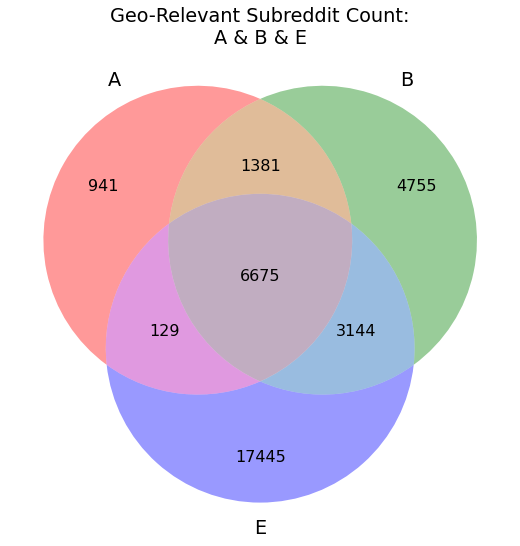

In [116]:
plt.figure(figsize=(10, 9))

lbls_ = ['A', 'B', 'E']

s_subs_a = (
    df_geo_new[mask_a_default]['subreddit_name'] + '-' +
    df_geo_new[mask_a_default]['country_name'] 
)
s_subs_b = (
    df_geo_new[mask_thresh_b]['subreddit_name'] + '-' +
    df_geo_new[mask_thresh_b]['country_name'] 
)
s_subs_e = (
    df_geo_new[mask_thresh_e]['subreddit_name'] + '-' +
    df_geo_new[mask_thresh_e]['country_name'] 
)

d_sets_abe = get_venn_sets3(
    s_subs_a, s_subs_b, s_subs_e, 
    *lbls_
)

ax = venn3_unweighted(
    [
        set(s_subs_a), 
        set(s_subs_b),
        set(s_subs_e),
    ],
    set_labels=lbls_,
)
plt.title(f"Geo-Relevant Subreddit Count:\n{' & '.join(lbls_)}");

# Get counts per country

In [117]:
print(df_geo_baseline['country_name'].nunique())

value_counts_and_pcts(
    df_geo_baseline,
    ['country_name']
)

15


,count,percent,cumulative_percent
country_name,,,
United Kingdom,"2,831",21.2%,21.2%
Germany,"2,199",16.5%,37.7%
Canada,"1,799",13.5%,51.2%
India,"1,748",13.1%,64.3%
Mexico,"1,196",9.0%,73.2%
Brazil,941,7.1%,80.3%
Australia,856,6.4%,86.7%
France,584,4.4%,91.1%
Italy,301,2.3%,93.4%


In [124]:
print(df_geo_new['country_name'].nunique())

value_counts_and_pcts(
    df_geo_new,
    ['country_name'],
    sort_index=True,
)

15


,count,percent,cumulative_percent
country_name,,,
Argentina,530,1.5%,1.5%
Australia,"2,252",6.5%,8.1%
Austria,"2,113",6.1%,14.2%
Brazil,"1,214",3.5%,17.7%
Canada,"4,593",13.3%,31.0%
Chile,"1,058",3.1%,34.1%
France,"1,024",3.0%,37.1%
Germany,"4,133",12.0%,49.1%
India,"3,505",10.2%,59.2%


In [120]:
print(threshold_b_sub)
print(threshold_e_country_standardized)

0.14
2.0


In [125]:
col_geo_relevant_output = 'geo_relevance_default'
mask_unrated_or_e = df_geo_new['grouped_rating'] == 'unrated_or_E'

In [127]:
print(df_geo_new['country_name'].nunique())
value_counts_and_pcts(
    df_geo_new,
    ['country_name', col_geo_relevant_output],
    sort_index=True,
    cumsum=False,
    top_n=None,
    count_type='subreddits',
    
).set_caption(f"All subreddits (including NSFW)")

15


In [132]:
print(df_geo_new['country_name'].nunique())
value_counts_and_pcts(
    df_geo_new[mask_unrated_or_e],
    ['country_name', ],
    sort_index=True,
    cumsum=False,
    top_n=None,
    count_type='subreddits',
).set_caption('Geo+culturally relevant: Only subreddits rated as E or unrated')

15


,subreddits_count,percent_of_subreddits
country_name,,
Argentina,317,1.5%
Australia,"1,708",7.8%
Austria,"1,088",5.0%
Brazil,718,3.3%
Canada,"4,003",18.4%
Chile,568,2.6%
France,660,3.0%
Germany,"1,721",7.9%
India,"1,983",9.1%


In [137]:
print(df_geo_new['country_name'].nunique())
value_counts_and_pcts(
    df_geo_new[mask_unrated_or_e],
    ['country_name', col_geo_relevant_output],
    sort_index=True,
    cumsum=False,
    top_n=None,
    count_type='subreddits',
    reset_index=True,
).set_caption('Geo+culturally relevant: Only subreddits rated as E or unrated').hide_index()

15


country_name,geo_relevance_default,subreddits_count,percent_of_subreddits
Argentina,False,228,1.0%
Argentina,True,89,0.4%
Australia,False,"1,336",6.1%
Australia,True,372,1.7%
Austria,False,"1,055",4.8%
Austria,True,33,0.2%
Brazil,False,352,1.6%
Brazil,True,366,1.7%
Canada,False,"3,043",14.0%
Canada,True,960,4.4%


In [138]:
print(df_geo_new['country_name'].nunique())
value_counts_and_pcts(
    df_geo_new[mask_unrated_or_e]
    .replace({'geo_relevance_default': {False: 'New Metrics', True: 'Old Metric'}}),
    ['country_name', col_geo_relevant_output],
    sort_index=True,
    cumsum=False,
    top_n=None,
    count_type='subreddits',
    reset_index=True,
).set_caption('Geo+culturally relevant: Only subreddits rated as E or unrated').hide_index()

15


country_name,geo_relevance_default,subreddits_count,percent_of_subreddits
Argentina,New Metrics,228,1.0%
Argentina,Old Metric,89,0.4%
Australia,New Metrics,"1,336",6.1%
Australia,Old Metric,372,1.7%
Austria,New Metrics,"1,055",4.8%
Austria,Old Metric,33,0.2%
Brazil,New Metrics,352,1.6%
Brazil,Old Metric,366,1.7%
Canada,New Metrics,"3,043",14.0%
Canada,Old Metric,960,4.4%


In [123]:
print(df_geo_new['country_name'].nunique())

value_counts_and_pcts(
    df_geo_new,
    ['country_name', 'grouped_rating'],
    sort_index=True,
    cumsum=False,
    top_n=None,
    count_type='subreddits',
    
)

15


In [123]:
print(df_geo_new['country_name'].nunique())

value_counts_and_pcts(
    df_geo_new,
    ['country_name', 'grouped_rating'],
    sort_index=True,
    cumsum=False,
    top_n=None,
    count_type='subreddits',
    
)

15


In [139]:
col_ = 'b_users_percent_by_subreddit'
print(col_)
style_df_numeric(
    df_geo_new.groupby(['country_name'])
    [col_].describe()
    ,
    float_round=2,
    pct_cols=['mean', 'min', 'max'],
    pct_labels=['%'],
    pct_digits=2,
    l_bar_simple=[
        'mean', '50%',
    ],
)

b_users_percent_by_subreddit


,count,mean,std,min,25%,50%,75%,max
country_name,,,,,,,,
Argentina,530,26.69%,0.29,0.54%,2.23%,12.83%,52.64%,91.78%
Australia,"2,252",22.60%,0.28,0.61%,4.46%,6.62%,29.64%,96.96%
Austria,"2,113",3.46%,0.09,0.40%,0.92%,1.31%,2.81%,95.13%
Brazil,"1,214",51.60%,0.34,0.93%,15.22%,59.25%,85.55%,98.89%
Canada,"4,593",26.01%,0.28,1.29%,8.40%,11.09%,28.79%,99.06%
Chile,"1,058",5.85%,0.15,0.43%,0.99%,1.45%,2.50%,98.30%
France,"1,024",33.48%,0.32,0.69%,5.26%,14.44%,70.24%,97.55%
Germany,"4,133",34.87%,0.33,0.94%,8.24%,15.67%,72.56%,99.24%
India,"3,505",32.77%,0.28,0.84%,7.98%,18.38%,60.74%,98.19%


In [141]:
col_ = 'e_users_percent_by_country_standardized'
print(col_)
style_df_numeric(
    df_geo_new.groupby(['country_name'])
    [col_].describe()
    ,
    float_round=2,
    # pct_cols=['mean', 'min', 'max'],
    # pct_labels=['%'],
    pct_digits=2,
    l_bar_simple=[
        'mean', '50%',
    ],
)

e_users_percent_by_country_standardized


,count,mean,std,min,25%,50%,75%,max
country_name,,,,,,,,
Argentina,530,3.40,1.59,-0.35,2.27,2.93,4.21,10.28
Australia,"2,252",2.88,1.69,-1.01,2.10,2.39,3.18,10.78
Austria,"2,113",2.69,0.87,-0.53,2.18,2.45,2.89,10.61
Brazil,"1,214",3.50,2.35,-1.36,2.02,2.95,4.85,10.65
Canada,"4,593",2.66,1.71,-0.95,2.01,2.39,3.16,10.78
Chile,"1,058",2.91,1.11,-0.27,2.24,2.57,3.13,10.52
France,"1,024",3.02,1.51,-1.11,2.14,2.64,3.70,10.47
Germany,"4,133",2.78,1.58,-1.58,2.05,2.48,3.41,10.37
India,"3,505",2.96,1.70,-1.37,2.08,2.62,3.60,10.64


# Focus on one country

In [151]:
col_a_display = 'geo relevance default'
col_b_display = 'b users percent by subreddit'
col_e_display = 'e users percent by country standardized'


In [152]:
country_ = 'Australia'
display(
    style_df_numeric(
        df_geo_new
        [df_geo_new['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[:30, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
display(  # only subs that are missing in metric A
    style_df_numeric(
        df_geo_new
        [(df_geo_new['country_name'] == country_) &
         (df_geo_new[col_a_display.replace(' ', '_')] == False)
         ]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[60:80, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)
(
    style_df_numeric(
        df_geo_new
        [df_geo_new['country_name'] == country_]
        .drop(['geo_country_code', 'subreddit_id', 'total_users_in_country_l28'], axis=1)
        .iloc[-30:, :]
        ,
        rename_cols_for_display=True,
        # int_cols=False,
        int_labels=['total_users_in', 'num_of_countries_', 'users_in_subreddit_from_country_l28',
                    'by_country_rank',
                    ],
        pct_digits=2,
        pct_cols=['b_users_percent_by_subreddit',
                  'c_users_percent_by_country',
                  'users_percent_by_country_avg',
                  ],
        pct_labels='',
        l_bar_simple=['b_users_percent_by_subreddit',
                      'c_users_percent_by_country',
                      'e_users_percent_by_country_standardized',
                      ],
    )
    .applymap(color_boolean, subset=[col_a_display])
    .applymap(highlight_b, subset=[col_b_display])
    .applymap(highlight_e, subset=[col_e_display])
    .hide_index()
)

rating name,primary topic,rating short,over 18,grouped rating,subreddit in v041 model,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,total users in subreddit l28,posts not removed l28,users l7,num of countries with visits l28,users percent by country avg,users percent by country stdev,type
Everyone,None,E,None,unrated_or_E,subreddit_in_model,tifu,Australia,False,4.18%,2.02,1.67%,21,False,True,"360,748","8,622,392","1,701","3,993,488",119,0.77%,0.00,public
Everyone,Movies,E,f,unrated_or_E,subreddit_in_model,movies,Australia,False,4.11%,2.02,1.78%,18,False,True,"385,912","9,386,088","6,041","3,837,260",119,0.92%,0.00,public
Everyone,None,E,None,unrated_or_E,subreddit_in_model,trueoffmychest,Australia,False,4.01%,2.03,1.58%,26,False,True,"341,134","8,516,187","13,456","3,490,448",119,0.73%,0.00,public
Everyone,Movies,E,None,unrated_or_E,subreddit_in_model,marvelstudios,Australia,False,4.12%,2.20,0.96%,54,False,True,"208,050","5,046,713","6,604","2,354,667",119,0.46%,0.00,public
Sexually Explicit,Mature Themes and Adult Content,X,f,over_18_or_X_M_D_V,subreddit_in_model,relationship_advice,Australia,False,4.66%,2.09,1.22%,37,False,True,"263,147","5,650,157","57,008","2,182,057",119,0.55%,0.00,public
Everyone,Ethics and Philosophy,E,None,unrated_or_E,subreddit_in_model,amitheasshole,Australia,False,4.64%,2.80,1.17%,39,False,True,"253,606","5,462,643","1,067","2,176,646",119,0.42%,0.00,public
Everyone,Gaming,E,f,unrated_or_E,subreddit_in_model,pokemon,Australia,False,4.08%,2.17,0.82%,67,False,True,"177,605","4,351,428","8,184","2,046,505",119,0.37%,0.00,public
Everyone,Women's Health,E,f,unrated_or_E,subreddit_in_model,twoxchromosomes,Australia,False,4.48%,2.45,1.11%,48,False,True,"240,466","5,372,133","2,964","1,786,909",119,0.43%,0.00,public
Everyone,Movies,E,f,unrated_or_E,subreddit_in_model,starwars,Australia,False,4.17%,2.26,0.91%,57,False,True,"197,265","4,733,595","5,028","1,682,741",119,0.37%,0.00,public
Everyone,Family and Relationships,E,f,unrated_or_E,subreddit_in_model,insaneparents,Australia,False,4.41%,2.25,0.62%,107,False,True,"134,510","3,052,594",275,"1,650,852",119,0.24%,0.00,public


rating name,primary topic,rating short,over 18,grouped rating,subreddit in v041 model,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,total users in subreddit l28,posts not removed l28,users l7,num of countries with visits l28,users percent by country avg,users percent by country stdev,type
Everyone,Technology,E,None,unrated_or_E,subreddit_in_model,googlepixel,Australia,False,4.87%,2.09,0.22%,395,False,True,"46,875","961,630","3,254","326,574",119,0.11%,0.00,public
Everyone,Internet Culture and Memes,E,None,unrated_or_E,subreddit_in_model,unresolvedmysteries,Australia,False,4.18%,2.48,0.19%,450,False,True,"41,178","984,635",178,"323,377",119,0.08%,0.00,public
Everyone,None,E,None,unrated_or_E,subreddit_in_model,buyitforlife,Australia,False,3.03%,2.11,0.13%,668,False,True,"29,016","958,079",928,"319,838",119,0.05%,0.00,public
Everyone,Family and Relationships,E,None,unrated_or_E,subreddit_in_model,femaledatingstrategy,Australia,False,4.90%,2.54,0.29%,296,False,True,"62,667","1,278,960",746,"316,815",119,0.12%,0.00,public
Everyone,Animals and Pets,E,f,unrated_or_E,subreddit_in_model,dogs,Australia,False,3.53%,2.82,0.16%,534,False,True,"34,955","988,979","5,337","311,797",119,0.05%,0.00,public
Everyone,Television,E,None,unrated_or_E,subreddit_in_model,rupaulsdragrace,Australia,False,4.72%,2.32,0.19%,453,False,True,"40,932","867,418","1,677","306,537",119,0.08%,0.00,public
Everyone,Learning and Education,E,f,unrated_or_E,subreddit_in_model,teachers,Australia,False,3.13%,2.27,0.15%,603,False,True,"31,628","1,011,216","4,292","294,449",119,0.06%,0.00,public
Everyone,Home and Garden,E,f,unrated_or_E,subreddit_in_model,gardening,Australia,False,4.52%,3.28,0.13%,707,False,True,"27,795","615,515","4,935","284,439",119,0.04%,0.00,public
Everyone,Tabletop Games,E,None,unrated_or_E,subreddit_in_model,criticalrole,Australia,False,4.39%,2.22,0.14%,661,False,True,"29,213","665,128",694,"284,156",118,0.05%,0.00,public
Everyone,Television,E,None,unrated_or_E,subreddit_in_model,bravorealhousewives,Australia,False,3.62%,2.98,0.14%,655,False,True,"29,499","815,999","1,672","282,852",119,0.04%,0.00,public


rating name,primary topic,rating short,over 18,grouped rating,subreddit in v041 model,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,relevance percent by subreddit,relevance percent by country standardized,users in subreddit from country l28,total users in subreddit l28,posts not removed l28,users l7,num of countries with visits l28,users percent by country avg,users percent by country stdev,type
Everyone,Music,E,None,unrated_or_E,subreddit_missing,spaceyjane,Australia,False,53.12%,1.50,0.00%,"48,915",True,False,85,160,5,53,4,0.00%,0.00,public
Everyone,Politics,E,f,unrated_or_E,subreddit_in_model,australiasimmeta,Australia,True,32.98%,1.71,0.00%,"47,064",True,False,94,285,10,52,10,0.00%,0.00,public
Everyone,None,E,None,unrated_or_E,subreddit_missing,backchatpodcast,Australia,False,82.81%,0.71,0.00%,"44,791",True,False,106,128,12,52,2,0.00%,0.00,public
None,None,None,None,unrated_or_E,subreddit_missing,jadeevice,Australia,False,66.07%,1.74,0.00%,"43,935",True,False,111,168,4,52,5,0.00%,0.00,public
None,None,None,f,unrated_or_E,subreddit_missing,littlesimz,Australia,True,5.68%,-0.29,0.00%,"76,658",False,False,21,370,7,52,11,0.00%,0.00,public
None,None,None,None,unrated_or_E,subreddit_missing,micthesnare,Australia,False,33.58%,1.49,0.00%,"61,093",True,False,45,134,4,52,4,0.00%,0.00,public
Mature,Gaming,M,None,over_18_or_X_M_D_V,subreddit_in_model,mojogaming,Australia,False,19.50%,1.33,0.00%,"64,277",True,False,39,200,25,52,7,0.00%,0.00,public
Everyone,None,E,None,unrated_or_E,subreddit_missing,nubtc,Australia,False,24.54%,1.32,0.00%,"63,335",True,False,40,163,12,52,10,0.00%,0.00,public
Everyone,Gaming,E,None,unrated_or_E,subreddit_missing,riseofrebellion,Australia,True,3.22%,-0.52,0.00%,"90,483",False,False,10,311,8,52,12,0.00%,0.00,public
None,None,None,t,over_18_or_X_M_D_V,subreddit_missing,soratedx,Australia,False,88.29%,0.71,0.00%,"46,193",True,False,98,111,7,52,2,0.00%,0.00,public


# Show subreddit examples


## Cricket

In [106]:
show_geo_score_for_sub_single_table_new_metrics(
    'cricket',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: cricket ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
cricket,English,83.70%,1,"2,254",en
cricket,German,0.97%,2,26,de
cricket,Luxembourgish,0.93%,3,25,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,cricket,India,False,21.857%,6.17,0.699%,62,0.061%,119,"127,598","18,260,996"
1,cricket,Australia,True,19.581%,4.52,0.528%,145,0.061%,119,"114,312","21,632,112"


In [107]:
show_geo_score_for_sub_single_table_new_metrics(
    'cricket',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new_raw,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: cricket ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
cricket,English,83.70%,1,"2,254",en
cricket,German,0.97%,2,26,de
cricket,Luxembourgish,0.93%,3,25,lb


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,cricket,India,False,21.857%,6.17,0.699%,62,0.061%,119,"127,598","18,260,996"
1,cricket,Australia,True,19.581%,4.52,0.528%,145,0.061%,119,"114,312","21,632,112"
2,cricket,United Kingdom,False,11.236%,0.86,0.150%,660,0.061%,119,"65,595","43,791,735"


## soccer

In [108]:
show_geo_score_for_sub_single_table_new_metrics(
    'soccer',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: soccer ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
soccer,English,62.39%,1,"4,508",en
soccer,Italian,2.60%,2,188,it
soccer,German,1.95%,3,141,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,soccer,Portugal,False,1.396%,2.32,1.250%,22,0.460%,119,"34,739","2,779,803"
1,soccer,United Kingdom,False,18.586%,1.75,1.056%,48,0.460%,119,"462,603","43,791,735"


In [109]:
show_geo_score_for_sub_single_table_new_metrics(
    'soccer',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new_raw,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: soccer ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
soccer,English,62.39%,1,"4,508",en
soccer,Italian,2.60%,2,188,it
soccer,German,1.95%,3,141,de


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,soccer,Portugal,False,1.396%,2.32,1.250%,22,0.460%,119,"34,739","2,779,803"
1,soccer,United Kingdom,False,18.586%,1.75,1.056%,48,0.460%,119,"462,603","43,791,735"


## Formula1

In [110]:
show_geo_score_for_sub_single_table_new_metrics(
    'formula1',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: formula1 ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
formula1,English,77.76%,1,"2,552",en
formula1,Norwegian,1.55%,2,51,no
formula1,Italian,1.34%,3,44,it


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,formula1,United Kingdom,False,13.199%,2.04,0.779%,76,0.319%,119,"341,286","43,791,735"


In [112]:
show_geo_score_for_sub_single_table_new_metrics(
    'formula1',
    df_geo_baseline=df_geo_baseline,
    df_geo_new=df_geo_new_raw,
    df_lang_by_subreddit=df_lang_by_subreddit,
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: formula1 ===

Top languages, by post [L28]


subreddit name,language name,language percent,language rank,language count,weighted language
formula1,English,77.76%,1,"2,552",en
formula1,Norwegian,1.55%,2,51,no
formula1,Italian,1.34%,3,44,it


,subreddit name,country name,geo relevance default,b users percent by subreddit,e users percent by country standardized,c users percent by country,d users percent by country rank,users percent by country avg,num of countries with visits l28,users in subreddit from country l28,total users in country l28
0,formula1,United Kingdom,False,13.199%,2.04,0.779%,76,0.319%,119,"341,286","43,791,735"
1,formula1,Portugal,False,0.783%,1.81,0.728%,65,0.319%,119,"20,237","2,779,803"
2,formula1,Austria,False,0.726%,1.51,0.661%,95,0.319%,119,"18,782","2,842,978"
3,formula1,Switzerland,False,0.645%,1.07,0.560%,100,0.319%,119,"16,686","2,978,529"
4,formula1,Australia,False,4.630%,1.04,0.553%,137,0.319%,119,"119,707","21,632,112"
5,formula1,Germany,False,4.842%,0.87,0.516%,125,0.319%,119,"125,202","24,269,505"
